In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [121]:
# build the dataset
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []

    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    #print(X.shape, Y.shape)
    return X, Y

In [148]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# training split, dev/validation split, test split
# 80%, 10%, 10%
# training split - optimize parameters of the model
# dev/val split - optimize hyperparameters of the model (eg size of hidden layer or embedding)
# test split - evaluate the performance of the model. Very sparingly, otherwise you end up training on
# the test split
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [149]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [150]:
sum(p.nelement() for p in parameters)

11897

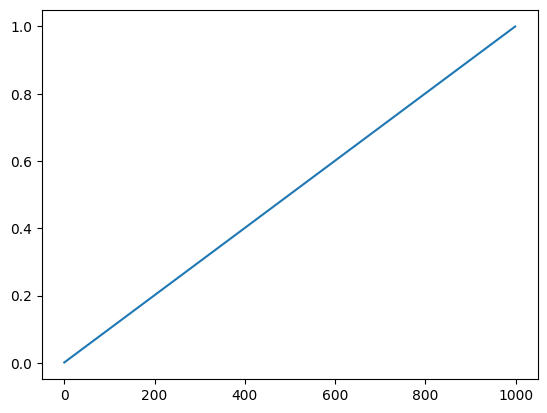

In [151]:
plt.plot(torch.arange(1000), torch.linspace(0.001, 1, 1000))

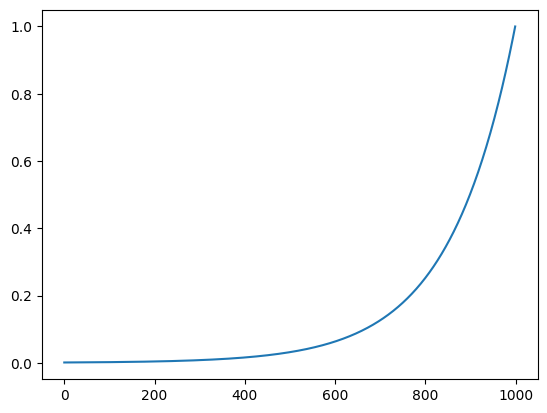

In [152]:
# try learning rates ranging from -0.001 to -1
lre = torch.linspace(-3, 0, 1000) # learning rate exponent
lrs = 10**lre # learning rates (between 0.001 and 1, exponentially stepped)
plt.plot(torch.arange(1000), lrs)

In [153]:
lri = []
lrei = []
lossi = []
loglossi = []
stepi = []

In [162]:
for i in range(50000):
    
    # minibatch construction
    batch_size = 32
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdims=True)
    #loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    #lr = lrs[i] # learning rate
    #lr = 0.1 # initial learning rate we determined
    lr = 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    #lri.append(lr)
    #lrei.append(lre[i])
    #lossi.append(loss.item())
    loglossi.append(loss.log10().item())
    stepi.append(i)
        
#print(loss.item())

In [163]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1696, grad_fn=<NllLossBackward0>)

In [164]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2015, grad_fn=<NllLossBackward0>)

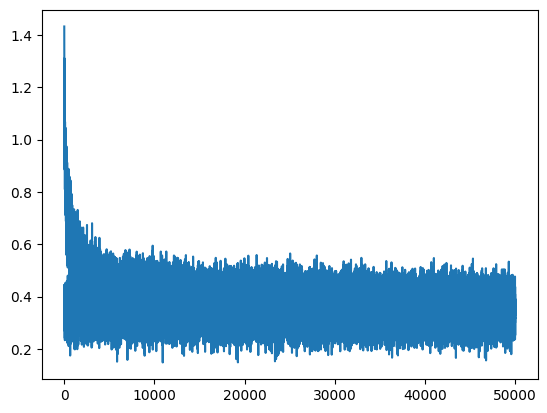

In [161]:
plt.plot(stepi, loglossi)

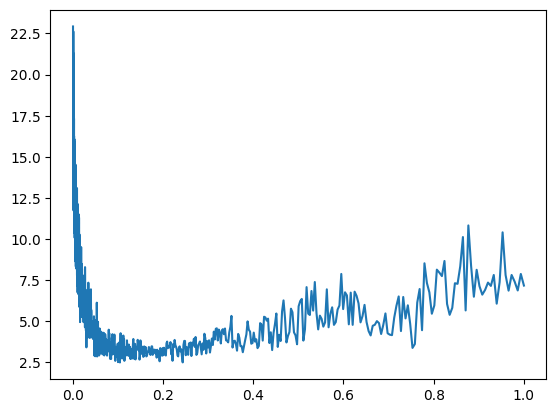

In [43]:
plt.plot(lri, lossi)

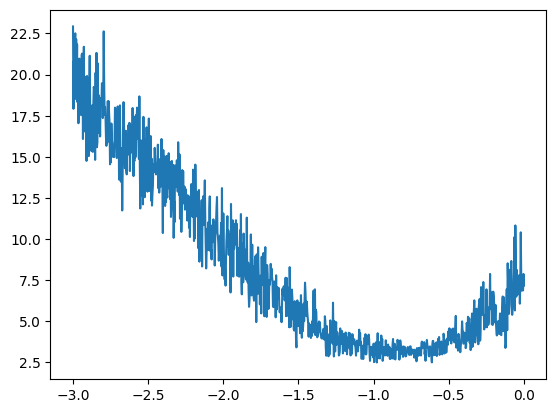

In [44]:
plt.plot(lrei, lossi)

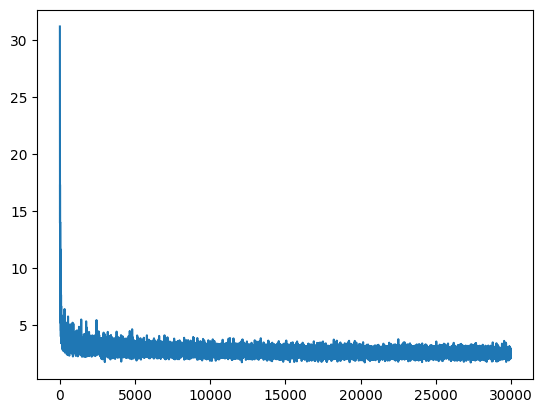

In [104]:
plt.plot(stepi, lossi)

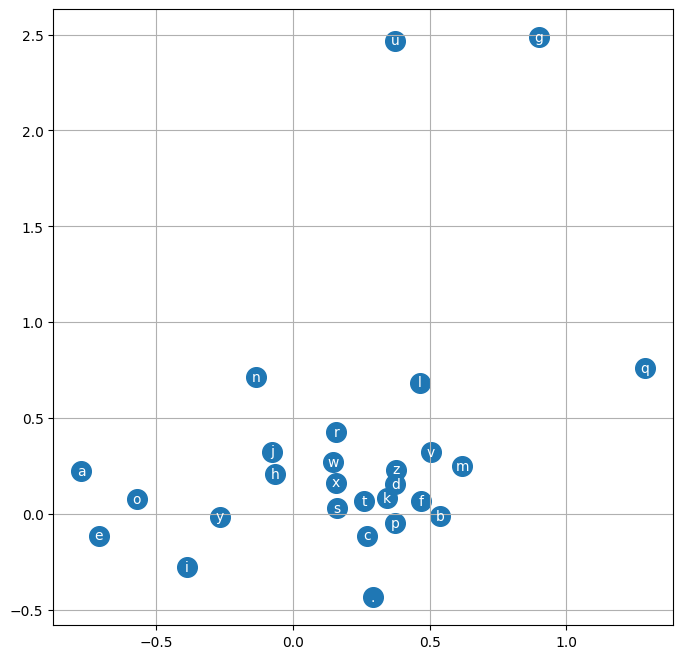

In [120]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [165]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

carmarela.
jhovah.
jari.
reety.
salaysleer.
hutraygen.
hailaqui.
nellara.
chaiir.
kaleigh.
ham.
joceferint.
salin.
alian.
quinathoniearyn.
kar.
eveirudi.
edde.
oik.
gine.
